In [1]:
import os
import pickle
import math
import random
import csv
from PIL import Image

import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

print('All modules imported.')

d:\self learning\anaconda3\envs\tf1.4.0\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\self learning\anaconda3\envs\tf1.4.0\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\self learning\anaconda3\envs\tf1.4.0\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\self learning\anaconda3\envs\tf1.4.0\lib\site-packages\ten

All modules imported.


# 1. Realod the preprocessed data


In [2]:
pickle_file = './pre-data.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['train_features']
    y_train = pickle_data['train_labels']
    X_valid = pickle_data['valid_features']
    y_valid = pickle_data['valid_labels']
    X_test = pickle_data['test_features']
    y_test = pickle_data['test_labels']
    signnames = pickle_data['signnames']
    del pickle_data  # Free up memory
    
# Shuffle the data set
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
print(len(signnames))
print('Data loaded.')

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)
43
Data loaded.


# 2. AlexNet Architecture


In [3]:
def AlexNet(x,KEEP_PROB,LAMBDA):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and
    # bias for each layer
    
    mu = 0 
    sigma = 0.1
    reg_loss = tf.zeros(1)
    
    # Conv1: Input = 32x32x3, Output = 28x28x9
    # Convolutional
    conv1_w = tf.Variable(tf.truncated_normal((5,5,3,9),mu,sigma))
    conv1_b = tf.Variable(tf.zeros(9))
    conv1 = tf.nn.conv2d(x,conv1_w,[1,1,1,1],'VALID') + conv1_b
    # Actcivation 
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x9, output = 14x14x9
    pool1 = tf.nn.max_pool(conv1,[1,2,2,1],[1,2,2,1],'VALID')
    
    # Conv2: Input = 14x14x9, output = 12x12x32
    # Convolutional
    conv2_w = tf.Variable(tf.truncated_normal((3,3,9,32),mu,sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2 = tf.nn.conv2d(pool1,conv2_w,[1,1,1,1],'VALID') + conv2_b
    # Activation
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 12x12x32, output = 6x6x32
    pool2 = tf.nn.max_pool(conv2,[1,2,2,1],[1,2,2,1],'VALID')
    
    # Conv3: Input = 6x6x32, output = 6x6x48
    # Convolutional 
    conv3_w = tf.Variable(tf.truncated_normal((3,3,32,48),mu,sigma))
    conv3_b = tf.Variable(tf.zeros(48))
    conv3 = tf.nn.conv2d(pool2,conv3_w,[1,1,1,1],'SAME') + conv3_b
    # Activation
    conv3 = tf.nn.relu(conv3)
    
    # Conv 4: Input = 6x6x48, Output = 6x6x64
    # Convolutional 
    conv4_w = tf.Variable(tf.truncated_normal((3,3,48,64),mu,sigma))
    conv4_b = tf.Variable(tf.zeros(64))
    conv4 = tf.nn.conv2d(conv3,conv4_w,[1,1,1,1],'SAME') + conv4_b
    # Activation 
    conv4 = tf.nn.relu(conv4)
    
    # Conv5: Input = 6x6x64, output = 6x6x96
    # Convolutional 
    conv5_w = tf.Variable(tf.truncated_normal((3,3,64,96),mu,sigma))
    conv5_b = tf.Variable(tf.zeros(96))
    conv5 = tf.nn.conv2d(conv4,conv5_w,[1,1,1,1],'SAME') + conv5_b
    # Activation
    conv5 = tf.nn.relu(conv5)
    # Pooling, Input = 6x6x96, Output = 3x3x96
    pool3 = tf.nn.max_pool(conv5,[1,2,2,1],[1,2,2,1],'VALID')
    
    # Flatten, Input = 3x3x96, output = 864
    flat = flatten(pool3)
    
    # full 1: Input = 864, Output = 400
    # Fully connected layer
    full1_w = tf.Variable(tf.truncated_normal((864,400),mu,sigma))
    full1_b = tf.Variable(tf.zeros(400))
    full1 = tf.matmul(flat,full1_w) + full1_b
    # Activation
    full1 = tf.nn.relu(full1)
    # Dropout
    full1 = tf.nn.dropout(full1,KEEP_PROB)
    
    # full 2: Input = 400, Output = 160
    # Fully connected layer
    full2_w = tf.Variable(tf.truncated_normal((400, 160), mu, sigma))
    full2_b = tf.Variable(tf.zeros(160))
    full2 = tf.matmul(full1, full2_w) + full2_b
    # Activation.
    full2 = tf.nn.relu(full2)
    # Dropout
    full2 = tf.nn.dropout(full2, KEEP_PROB)
    
    # output : Fully Connected. Input = 160. Output = 43.
    full3_w = tf.Variable(tf.truncated_normal((160, 43), mu, sigma))
    full3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(full2, full3_w) + full3_b

    if LAMBDA != 0:
        reg_loss = tf.nn.l2_loss(conv1_w) + tf.nn.l2_loss(conv2_w) + tf.nn.l2_loss(conv3_w) + tf.nn.l2_loss(conv4_w) + tf.nn.l2_loss(conv5_w) + tf.nn.l2_loss(full1_w) + tf.nn.l2_loss(full2_w) + tf.nn.l2_loss(full3_w)
    
    return logits, reg_loss

# 3. Training
## 3.1 Strategy
#### learning rate decay: tf.train.exponential_decay(INITIAL_LEARNING_RATE, global_step=global_step, decay_steps=150, decay_rate=0.95) is used for decay learing rate, global_step increment after each step only when you give it to minimize(loss_op, global_step=global_step) as the global_step paramenter.


In [4]:
# Placeholder
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder_with_default(1.0, shape=())
LAMBDA = tf.placeholder_with_default(0.0, shape=())

# Hyperparameters
LEARNING_RATE = 5e-4
EPOCHS = 30
BATCH_SIZE = 64

# parameters for learning rate decay
# global_step = tf.Variable(0, trainable=False)
# LEARNING_RATE = tf.train.exponential_decay(1e-2, global_step=global_step, decay_steps=180, decay_rate=0.96)

# Train method
logits, reg_loss = AlexNet(x, keep_prob, LAMBDA)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_op = tf.reduce_mean(cross_entropy)
# batch gradient descent optimizer
# optimizer = tf.train.GradientDescentOptimizer(learning_rate = LEARNING_RATE)
# Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
# train_op = optimizer.minimize(loss_op, global_step=global_step)
train_op = optimizer.minimize(loss_op)

## 3.2 Evalution

In [5]:

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_op, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## 3.3 Train the model

A validation set can be used to assess how well the model is performing. 

A low accuracy on the training and validation sets imply **underfitting.** 

A high accuracy on the training set but low accuracy on validation set implies **overfitting.**

**LAMBDA** controls the regulization degree, if LAMBDA is too large, the model will **underfitting**

if LAMBDA is too small, the model will be **overfitting**


In [6]:
%%time
# 2min 7s
train_accuracy = []
valid_accuracy = []
learning_rates = []
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        total_train_acc = 0
        print("EPOCH {} :".format(i+1), end=' ')
        for offset in range(0, num_examples, BATCH_SIZE):# 34799 / BATCH_SIZE = 271
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, train_acc = sess.run([train_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5, LAMBDA: 1e-5})
#             _, train_acc, lr = sess.run([train_op, accuracy_op, LEARNING_RATE], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
            total_train_acc += (train_acc * len(batch_x))
        train_accuracy.append(total_train_acc / num_examples)
        valid_acc = evaluate(X_valid, y_valid)
        valid_accuracy.append(valid_acc)
        print("Valid Accuracy = {:.3f}".format(valid_acc))
                
    saver.save(sess, './model/alexnet.ckpt')
    print("Model saved")

Training...
EPOCH 1 : Valid Accuracy = 0.672
EPOCH 2 : Valid Accuracy = 0.848
EPOCH 3 : Valid Accuracy = 0.903
EPOCH 4 : Valid Accuracy = 0.909
EPOCH 5 : Valid Accuracy = 0.931
EPOCH 6 : Valid Accuracy = 0.936
EPOCH 7 : Valid Accuracy = 0.938
EPOCH 8 : Valid Accuracy = 0.942
EPOCH 9 : Valid Accuracy = 0.941
EPOCH 10 : Valid Accuracy = 0.950
EPOCH 11 : Valid Accuracy = 0.934
EPOCH 12 : Valid Accuracy = 0.948
EPOCH 13 : Valid Accuracy = 0.951
EPOCH 14 : Valid Accuracy = 0.947
EPOCH 15 : Valid Accuracy = 0.955
EPOCH 16 : Valid Accuracy = 0.959
EPOCH 17 : Valid Accuracy = 0.944
EPOCH 18 : Valid Accuracy = 0.952
EPOCH 19 : Valid Accuracy = 0.950
EPOCH 20 : Valid Accuracy = 0.960
EPOCH 21 : Valid Accuracy = 0.958
EPOCH 22 : Valid Accuracy = 0.963
EPOCH 23 : Valid Accuracy = 0.948
EPOCH 24 : Valid Accuracy = 0.956
EPOCH 25 : Valid Accuracy = 0.962
EPOCH 26 : Valid Accuracy = 0.958
EPOCH 27 : Valid Accuracy = 0.949
EPOCH 28 : Valid Accuracy = 0.958
EPOCH 29 : Valid Accuracy = 0.962
EPOCH 30 : 

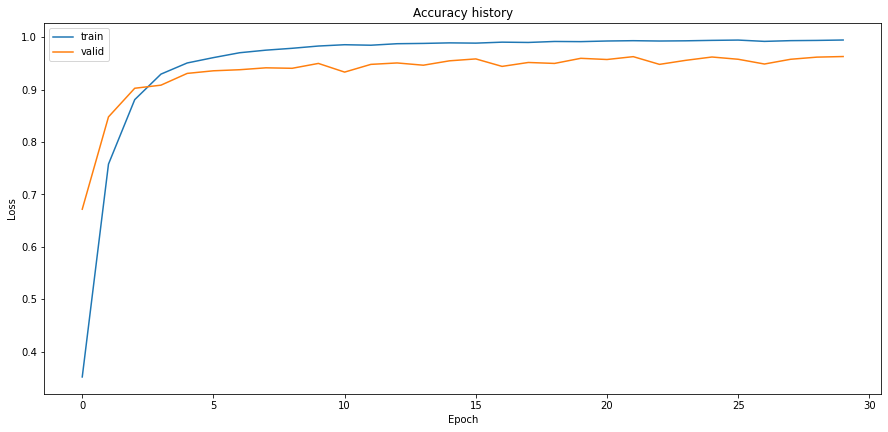

In [7]:
plt.subplot(2, 1, 2)
plt.plot(train_accuracy, label='train')
plt.plot(valid_accuracy, label='valid')
plt.title('Accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gcf().set_size_inches(15, 15)
plt.legend()
plt.show()


No handles with labels found to put in legend.


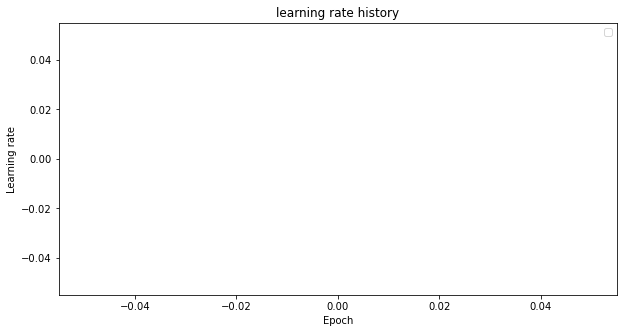

In [10]:
plt.plot(learning_rates)
plt.title('learning rate history')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.gcf().set_size_inches(10, 5)
plt.legend()
plt.show()

# 4. Testing 
## 4.1 Test the model on testing dataset

INFO:tensorflow:Restoring parameters from ./model/alexnet.ckpt


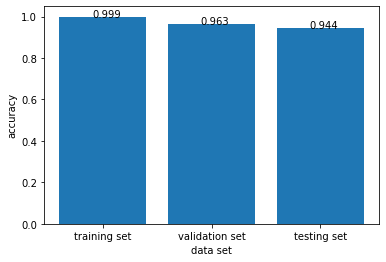

In [11]:
with tf.Session() as sess:
    saver.restore(sess, './model/alexnet.ckpt')
    train_accuracy = evaluate(X_train, y_train)
    valid_accuracy = evaluate(X_valid, y_valid)
    test_accuracy = evaluate(X_test, y_test)
    
accuracys = [train_accuracy, valid_accuracy, test_accuracy]
tick_labels = ["training set", "validation set", "testing set"]
plt.bar(range(3), accuracys)
plt.xlabel('data set')
plt.ylabel('accuracy')
plt.xticks(range(3), tick_labels)
for x_,y_ in zip(range(3), accuracys):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)
plt.show()